In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numpy import random as rand
import pandas as pd
from math import e
from tqdm import tqdm
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import cv2

In [2]:
#RANDOM GEOMETRIC

def networkRGG_cumulative(G,N,macrosteps,pars):
    
    vec_a_mean=[]           #empty vector to be filled with the mean of alpha at each macrostep loop
    vec_x=[]                #empty vector to be filled with the fraction of cooperators at each macrostep loop
    check=[]
    a_vec = list(nx.get_node_attributes(G, 'alpha').values())       #list of alpha of all nodes, different at every macrostep
    s_vec = list(nx.get_node_attributes(G, 'strategy').values())    #list of strategy of all nodes, different at every macrostep
 
    neighbours = [list(nx.all_neighbors(G, node)) for node in range(N)]
    
    for t in tqdm(macrosteps, desc = 'Progress Bar'):
        
        nx.set_node_attributes(G,{ n: a_vec[n] for n in range(N) },'alpha')
        nx.set_node_attributes(G,{ n: s_vec[n] for n in range(N) },'strategy')
        
        vec_a_mean = np.append(vec_a_mean, np.mean(a_vec))       #vector with mean of alpha at each macrostep
        vec_x = np.append(vec_x, np.mean(s_vec))                 #vector with fraction of cooperators at each macrostep

        s_vec=[]
        a_vec=[]
        cumulative_payoffs=[]  
        cum_x=[]
        
        #calculate the cumulative payoff and x_neighbours for all players
        for node in range(N):
            a1,s1 = G.nodes[node]['alpha'] , G.nodes[node]['strategy']
            pm1=pd.DataFrame(np.array([[-pars['p']*pars['cd']*(1-pars['e'])*(1-pars['d'])-(1-a1)*pars['cn'], -pars['p']*pars['cd']*(1-pars['e'])-(1-a1)*pars['cn']],[-pars['p']*pars['cd']*(1-pars['d']), -pars['p']*pars['cd']]]), index = [1, 0], columns=[1, 0])
            pi=0
            sum_x_neigh = 0
            
            for neighbor in neighbours[node]:
                s2 = G.nodes[neighbor]['strategy']
                pi =  pi + pm1.at[int(s1),int(s2)]
                sum_x_neigh = sum_x_neigh + s2
                
            cumulative_payoffs = np.append(cumulative_payoffs,pi)
            if len(neighbours[node])>0:
                cum_x = np.append(cum_x,sum_x_neigh/len(neighbours[node]))
            else: 
                cum_x = np.append(cum_x,s1)
        
        for pos1 in range(N):
            
            if len(neighbours[pos1])==0: 
                a1,s1 = G.nodes[pos1]['alpha'],G.nodes[pos1]['strategy'] 
                s_vec=np.append(s_vec,s1)
                a_vec=np.append(a_vec,a1)
                continue
            
            a1,s1 = G.nodes[pos1]['alpha'] , G.nodes[pos1]['strategy']  
            pos2 = rand.choice(list(neighbours[pos1]))
            s2 = G.nodes[pos2]['strategy']
            
            pi_1=cumulative_payoffs[pos1]
            pi_2=cumulative_payoffs[pos2]
            delta_pi = pi_2-pi_1              

            prob = 1/(1+e**(-beta*delta_pi))
            
            a1_new = a1 + pars['gamma']*(2*(cum_x[pos1])-1)*a1*(1-a1)
            if a1_new>=1: a1_new=0.99
            if a1_new<=0: a1_new=0.01

            if rand.random()<prob: s1_new = s2
            else: s1_new = s1
            
            a_vec=np.append(a_vec,a1_new)
            s_vec=np.append(s_vec,s1_new)
     
    return G, vec_x, vec_a_mean

Progress Bar: 100%|██████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.36it/s]


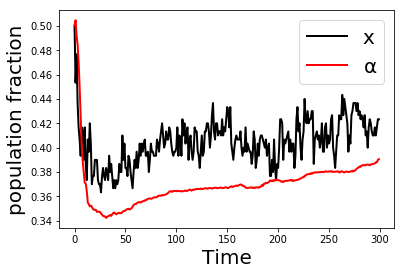

In [3]:
# Parameters
pars={} 
pars['p']=0.4
pars['cd']=1
pars['e']=0.9
pars['d']=0.5
pars['cn']=0.65
pars['gamma']=1

rand.seed(0)
beta=1
N=300
n_coop=150
radius=0.083
d=6
nums = np.zeros(N) 
nums[:n_coop] = 1
np.random.shuffle(nums)
vector=np.linspace(0.01,0.99,N)

#G = nx.random_regular_graph(d, N, seed=None)
G = nx.random_geometric_graph(N, radius, dim=2, pos=None, p=2, seed=None)
nx.set_node_attributes(G,{ n: vector[n] for n in range(N) },'alpha')
nx.set_node_attributes(G,{ n: nums[n] for n in range(N) },'strategy')
    
macrosteps = list(range(300))

r= networkRGG_cumulative(G,N,macrosteps,pars)

new_a_vec=np.transpose(r[0])    #final updated vector containing the alpha of each player

# Visualize
plt.plot(macrosteps,r[1],linewidth=2,color='k')
plt.plot(macrosteps,r[2],linewidth=2,color='r')
plt.xlabel('Time',fontsize=20)
plt.ylabel('population fraction',fontsize=20)
plt.legend(['x','α'],fontsize=20)
plt.show()

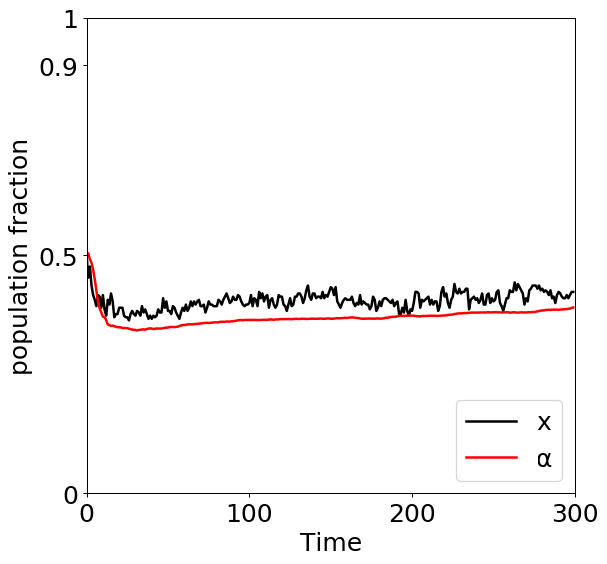

In [4]:
# Visualize
fig1,ax = plt.figure(figsize=(7, 7), dpi=90), plt.axes()
ax.set_xlim([0, 300])
ax.set_ylim([0, 1])
ax.set_xticks(np.linspace(0,300,4))
ax.set_xticklabels(np.linspace(0,300,4).astype(int),fontsize=20) 
ax.set_yticks([0,0.5,0.9,1])
ax.set_yticklabels([0,0.5,0.9,1],fontsize=20) 
plt.plot(macrosteps,r[1],linewidth=2,color='k')
plt.plot(macrosteps,r[2],linewidth=2,color='r')
plt.xlabel('Time',fontsize=20)
plt.ylabel('population fraction',fontsize=20)
plt.legend(['x','α'],fontsize=20,loc='lower right')
plt.show()

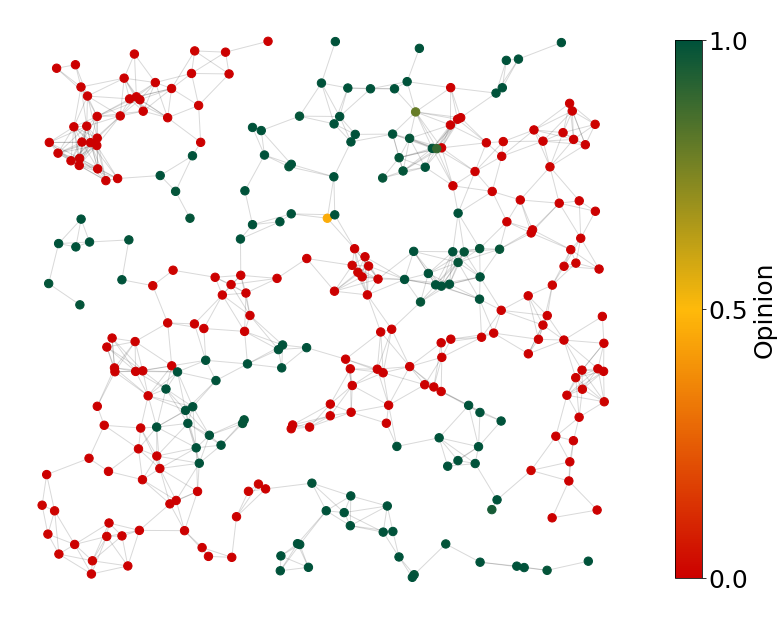

In [5]:
#plot of alpha distribution

my_gradient=LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#CC0000-FFBA0A-00523A
    (0.000, (0.800, 0.000, 0.000)),
    (0.500, (1.000, 0.729, 0.039)),
    (1.000, (0.000, 0.322, 0.227))))

pos = nx.get_node_attributes(r[0], 'pos')
nodes = r[0].nodes()
colors = list(nx.get_node_attributes(r[0], 'alpha').values())
plt.figure(figsize=(14, 11))
nx.draw_networkx_edges(r[0], pos, alpha=0.15)
nc=nx.draw_networkx_nodes(r[0],pos,nodelist=nodes,node_color=colors, label=None, node_size=70,cmap=my_gradient)
cbar=plt.colorbar(nc, shrink=0.9,ticks=[0,0.5,1]).set_label(label='Opinion',size=25)
nc.set_clim(0, 1)
nc.figure.axes[1].tick_params(axis="both",labelsize=25)
plt.axis("off")
plt.show()

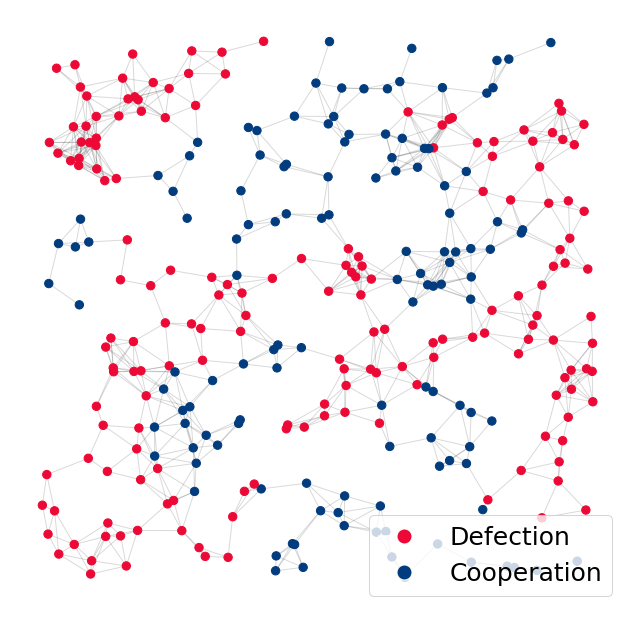

In [6]:
#plot of strategy distribution
#0081A7 
#DA1B3E
colors = list(nx.get_node_attributes(r[0], 'strategy').values())

fig=plt.figure(figsize=(11, 11))
nx.draw_networkx_edges(r[0], pos, alpha=0.15)
nc=nx.draw_networkx_nodes(r[0],pos,nodelist=nodes,node_color=colors, node_size=70,cmap=ListedColormap(['#EC0936', '#003C7E'],N=2))
if np.sum(colors)==len(colors): nc=nx.draw_networkx_nodes(r[0],pos,nodelist=nodes,node_color=colors, node_size=60,cmap=ListedColormap(['xkcd:pine', 'xkcd:pine'],N=2))
legend_elements=[Line2D([0],[0],marker='o',color='white', markersize=15,markerfacecolor="#EC0936", label='Defection'),Line2D([0], [0], marker='o', color='white', markersize=15,markerfacecolor="#003C7E",label='Cooperation')]
plt.legend(handles=legend_elements,fontsize=25,  loc='lower right')
plt.axis("off")
plt.show()

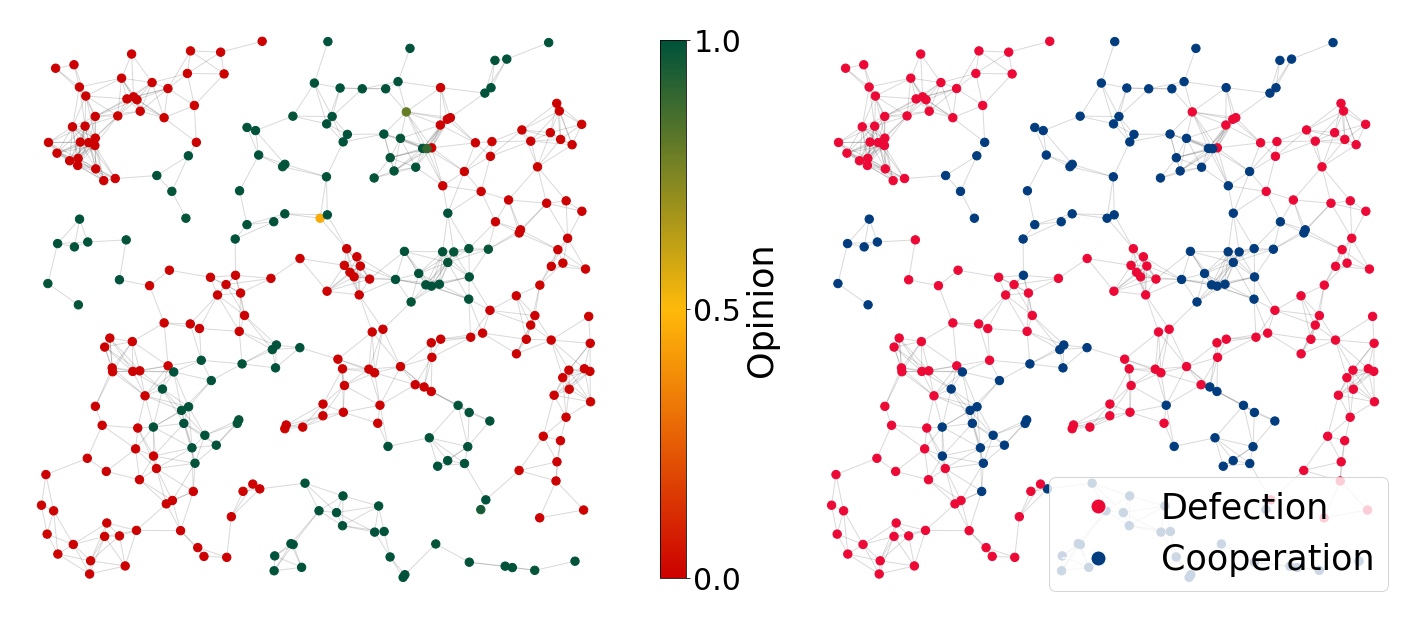

In [7]:
# plot of alpha distribution
my_gradient=LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#CC0000-FFBA0A-00523A
    (0.000, (0.800, 0.000, 0.000)),
    (0.500, (1.000, 0.729, 0.039)),
    (1.000, (0.000, 0.322, 0.227))))
pos = nx.get_node_attributes(G, 'pos')
nodes = G.nodes()
colors = list(nx.get_node_attributes(G, 'alpha').values())
fig=plt.figure(figsize=(25, 11))
fig.add_subplot(1,9, (1,5))
nx.draw_networkx_edges(G, pos, alpha=0.15)
nc=nx.draw_networkx_nodes(G,pos,nodelist=nodes,node_color=colors, label=None, node_size=70,cmap=my_gradient)

cbar=plt.colorbar(nc, shrink=0.9,ticks=[0,0.5,1]).set_label(label='Opinion',size=35)

nc.set_clim(0, 1)
nc.figure.axes[1].tick_params(axis="both",labelsize=30)
plt.axis("off")

# plot of strategy distribution
colors = list(nx.get_node_attributes(G, 'strategy').values())
fig.add_subplot(1,9, (6,9))
nx.draw_networkx_edges(G, pos, alpha=0.15)
nc=nx.draw_networkx_nodes(G,pos,nodelist=nodes,node_color=colors, node_size=70,cmap=ListedColormap(['#EC0936', '#003C7E'],N=2))
if np.sum(colors)==len(colors): nc=nx.draw_networkx_nodes(G,pos,nodelist=nodes,node_color=colors, node_size=50,cmap=ListedColormap(['#EC0936', '#003C7E'],N=2))
legend_elements=[Line2D([0],[0],marker='o',color='white', markersize=15,markerfacecolor="#EC0936", label='Defection'),Line2D([0], [0], marker='o', color='white', markersize=15,markerfacecolor="#003C7E",label='Cooperation')]
plt.legend(handles=legend_elements,fontsize=35,  loc='lower right')
plt.axis("off")        

plt.show(block=True)

In [18]:
from math import pi
pi*(299)*radius**2,2*len(G.edges())/N

(6.471087105383447, 5.78)

In [39]:
(pars['p']*pars['cd']*pars['d'])/(pars['cn']*(1-np.mean(list(nx.get_node_attributes(r[0], 'alpha').values())))-pars['p']*pars['cd']*pars['e']+pars['p']*pars['cd']*pars['e']*pars['d'])

-2.7093274310468334